<a href="https://colab.research.google.com/github/pedroalmir/trends-ehealth/blob/main/ngram_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installs

In [1]:
!pip install unidecode

     |████████████████████████████████| 235 kB 27.5 MB/s 


In [29]:
import re
import csv
import nltk
import unidecode
import unicodedata
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import auth
from google.colab import drive
import matplotlib.pyplot as plt
from google.auth import default
from nltk.corpus import stopwords
from pydrive.auth import GoogleAuth
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from oauth2client.client import GoogleCredentials
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Google Authentication

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
creds, _ = default()

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Getting Raw Data

In [42]:
folder_path = '/content/drive/My Drive/PedroAlmir/09_Doutorado/UFC/projetos/26_Trends_eHealth/datasets/'
file_name = '20220411-mhealth-updated-dataset-without-duplicates.csv'

In [74]:
df = pd.read_csv(folder_path + file_name, sep=',', quoting=csv.QUOTE_ALL)
df.shape

(1816, 14)

# Preprocessing

In [52]:
min_length = 3
lemmatizer = WordNetLemmatizer()
count_vectorizer = CountVectorizer(stop_words='english', min_df=5, max_df=0.8, ngram_range=(1, 1))

nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')
nltk.download('wordnet')

# add appropriate words that will be ignored in the analysis
ADDITIONAL_STOPWORDS = ['covfefe']

stops = set(stopwords.words("english") + ADDITIONAL_STOPWORDS)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
def remove_tag_code(html_text):
  soup = BeautifulSoup(html_text, "lxml")
  codes = soup("code")
  for code in codes:
    code.decompose()
  return soup.text

In [47]:
def textblob_tokenizer(str_input):
    global N, execucoes
    letters_only = re.sub(u'[^a-zA-ZáéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ ]', ' ', remove_tag_code(str_input))
    tokens = nltk.word_tokenize(letters_only.lower())
    tokens = [unidecode.unidecode(token) for token in tokens if not token in stops and len(token) >= min_length]
    #tokens = [stemmer.stem(token) for token in tokens if not token in stops]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]    
    tokens = [unicodedata.normalize('NFKD', token).encode('ascii', 'ignore').decode('utf-8', 'ignore') for token in tokens]
    return ' '.join(tokens)

In [67]:
# Testing
print('|_ Original body\n\n', df['Body'][0])
print('|_ Body without code\n\n', remove_tag_code(df['Body'][0]))
print('|_ Body preprocessed\n\n', textblob_tokenizer(df['Body'][0]))

|_ Original body

 <p>I made a function to know if a person is connected to an API. After creating a new token
I want to know if the tokens are valid or not. I'm kind of stuck here. How can you make that dummy call and check the validity of the tokens?</p>

<pre><code>private bool IsConnectedToFitbit()
{
    var access = StaminaFacade.GetBenefiaryAccess(this.Contact.EmployeeId,   ProviderCode.Fitbit);

    if (string.IsNullOrEmpty(access.AuthorizationKey1) || string.IsNullOrEmpty(access.AuthorizationKey2))
    return false;
    else
    {
        var tokens = new OAuthTokens
        {
            ConsumerKey = PortalSettings.FitbitAppId,
            ConsumerSecret = PortalSettings.FitbitAppSecret,
            AccessToken = access.AuthorizationKey1,
            AccessTokenSecret = access.AuthorizationKey2
        };

        //TODO: make a dummy call to fitbit to check if tokens are valid

        return true;
</code></pre>

|_ Body without code

 I made a function to know if a person i

In [75]:
df = df.drop(columns=['ID', 'AcceptedAnswerId', 'HasAcceptedAnswer', 'CreationDate', 
                      'Score', 'ViewCount', 'OwnerUserId', 'OwnerDisplayName', 'Tags', 
                      'AnswerCount', 'CommentCount', 'FavoriteCount'], axis=1)

df['text'] = df['Title'] + ' ' + df['Body']
questions = df['text'].str.lower()
df = df.drop(columns=['Title', 'Body'], axis=1)

df['text_processed'] = [textblob_tokenizer(question) for question in questions]
df.head()

,text,text_processed
0,How to make a dummy call to check if tokens ar...,make dummy call check token valid made functio...
1,How can I use FitBit API for website developme...,use fitbit api website development trying use ...
2,ROAuth R and FitBit API Error: No Authorizatio...,roauth fitbit api error authorization header p...
3,Oauth authentification to Fitbit using httr <p...,oauth authentification fitbit using httr tryin...
4,I am getting error while trying to get profile...,getting error trying get profile detail fitbit...


# N-Gram Data Analysis

In [79]:
def getWords(text_column):
    wholetext = ''.join(str(text_column.tolist()))
    wholetext = textblob_tokenizer(wholetext)
    tokens = re.sub(r'[^\w\s]', '', wholetext).split()
    return [lemmatizer.lemmatize(word) for word in tokens]

In [81]:
def getNgrams(words, n):
    return pd.Series(nltk.ngrams(words, n))

In [82]:
def countNGrams(words, n):
    return getNgrams(words, n).value_counts()

In [85]:
words_arr = getWords(df['text_processed'])

In [86]:
bigrams_series = countNGrams(words_arr, 2)[:10]
trigrams_series = countNGrams(words_arr, 3)[:10]

# Data Visualization

In [147]:
def buildGraph(series, title, xaxis_label, yaxis_label):
    fig, ax = plt.subplots()
    values = series.sort_values()
    values.plot.barh(color='blue', width=.9, figsize=(12, 8))
    for i, v in enumerate(values):
        ax.text(v, i-0.1, str(v), color='blue', fontweight='bold')

    plt.title(title)
    plt.ylabel(xaxis_label)
    plt.xlabel(yaxis_label)

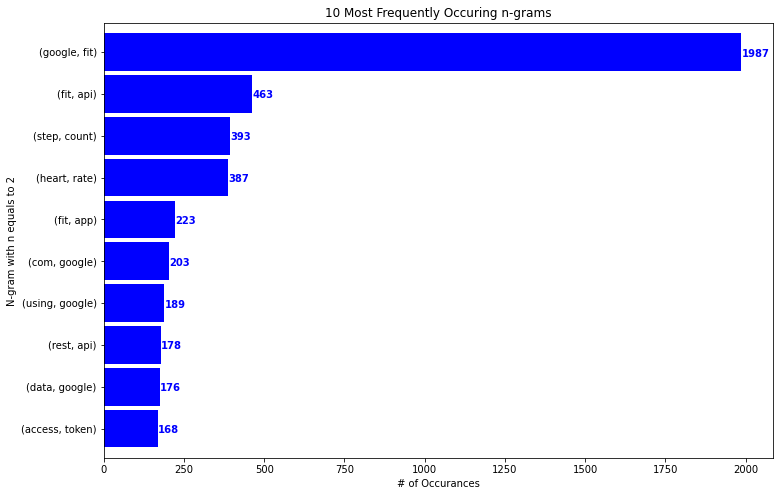

In [148]:
buildGraph(bigrams_series, '10 Most Frequently Occuring n-grams', 'N-gram with n equals to 2', '# of Occurances')

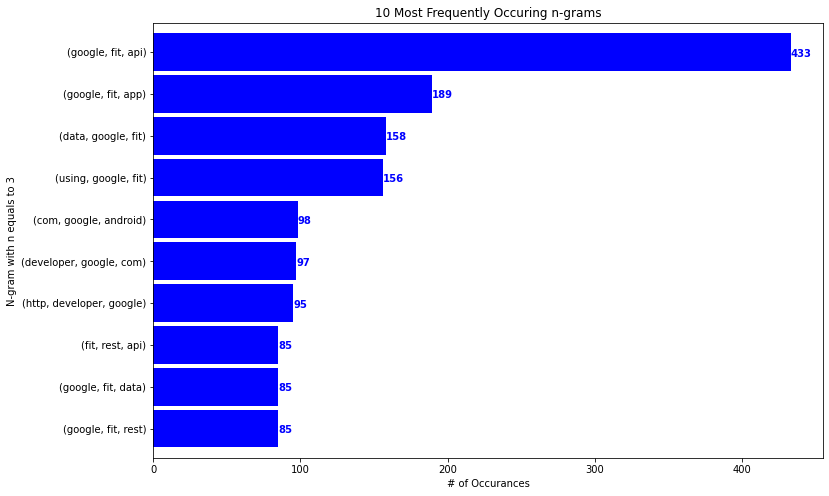

In [149]:
buildGraph(trigrams_series, '10 Most Frequently Occuring n-grams', 'N-gram with n equals to 3', '# of Occurances')

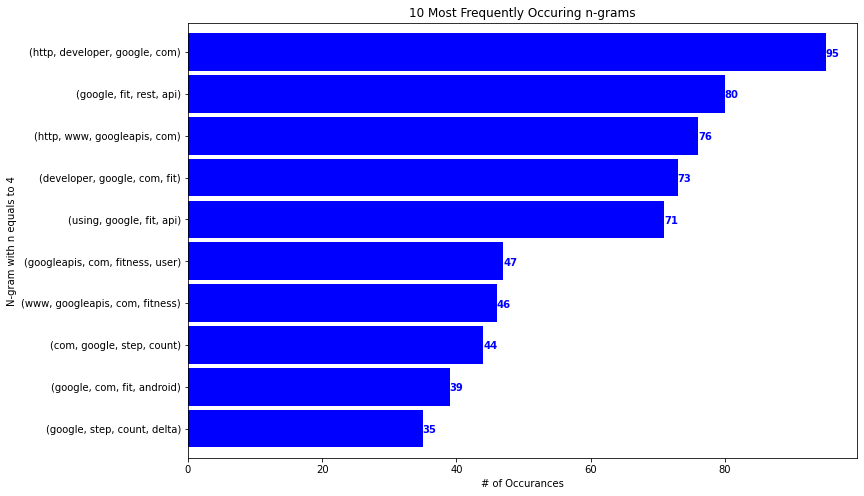

In [150]:
series = countNGrams(words_arr, 4)[:10]
buildGraph(series, '10 Most Frequently Occuring n-grams', 'N-gram with n equals to 4', '# of Occurances')

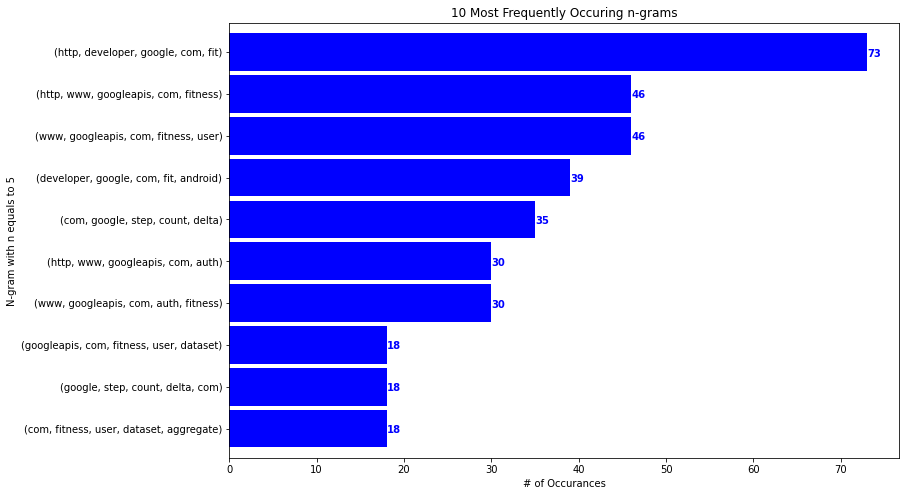

In [151]:
series = countNGrams(words_arr, 5)[:10]
buildGraph(series, '10 Most Frequently Occuring n-grams', 'N-gram with n equals to 5', '# of Occurances')

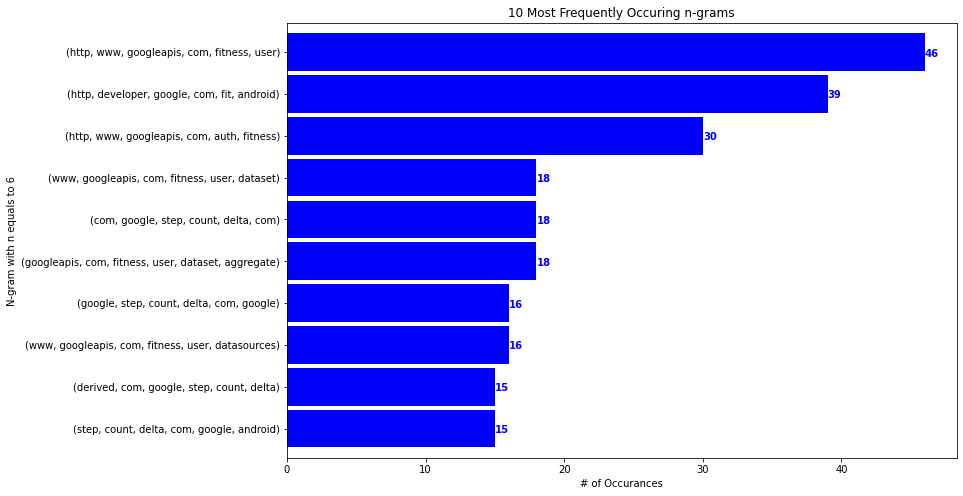

In [152]:
series = countNGrams(words_arr, 6)[:10]
buildGraph(series, '10 Most Frequently Occuring n-grams', 'N-gram with n equals to 6', '# of Occurances')

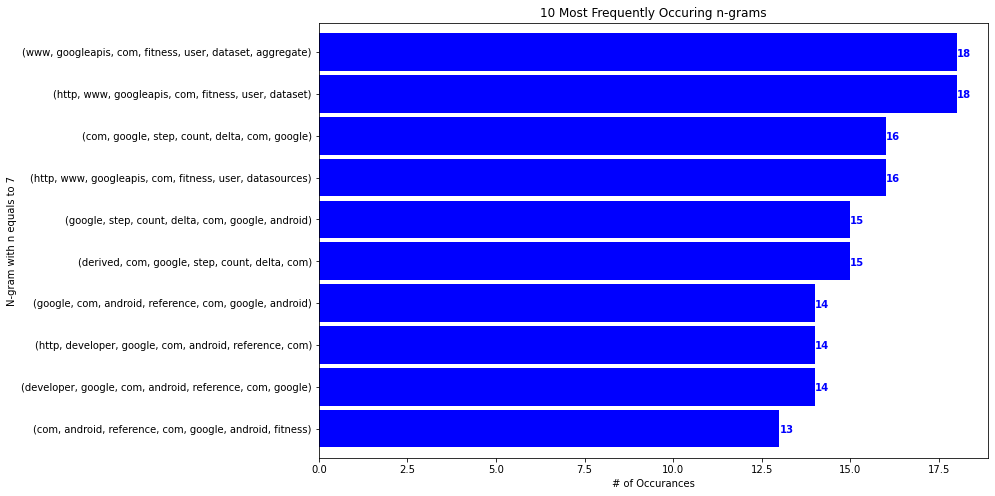

In [153]:
series = countNGrams(words_arr, 7)[:10]
buildGraph(series, '10 Most Frequently Occuring n-grams', 'N-gram with n equals to 7', '# of Occurances')

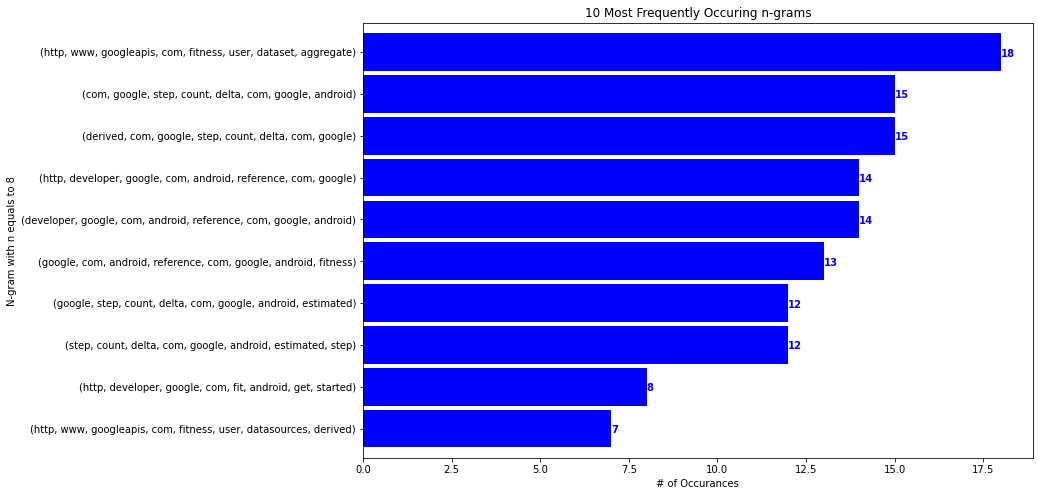

In [154]:
series = countNGrams(words_arr, 8)[:10]
buildGraph(series, '10 Most Frequently Occuring n-grams', 'N-gram with n equals to 8', '# of Occurances')

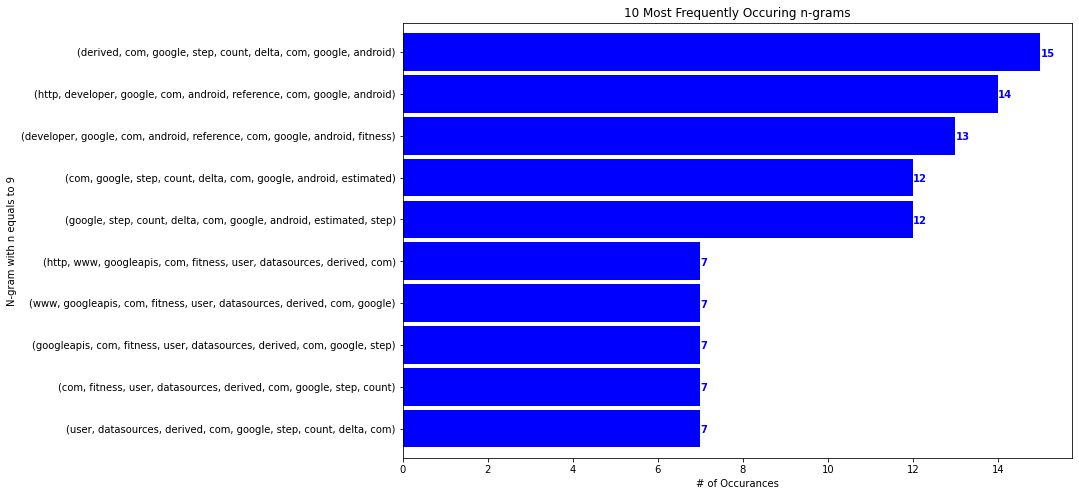

In [155]:
series = countNGrams(words_arr, 9)[:10]
buildGraph(series, '10 Most Frequently Occuring n-grams', 'N-gram with n equals to 9', '# of Occurances')

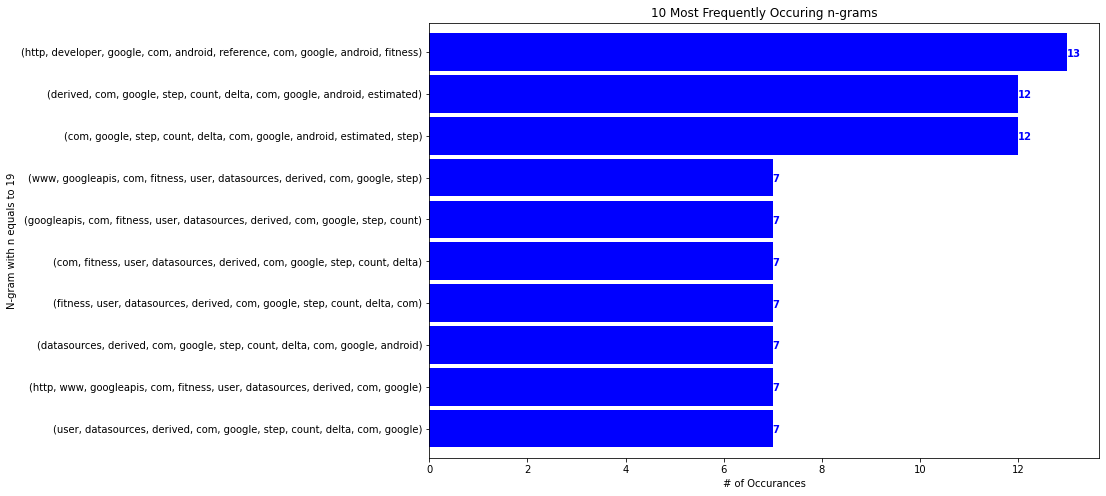

In [156]:
series = countNGrams(words_arr, 10)[:10]
buildGraph(series, '10 Most Frequently Occuring n-grams', 'N-gram with n equals to 19', '# of Occurances')

# Export data

In [182]:
countNGrams(words_arr, 11)[:20]

(derived, com, google, step, count, delta, com, google, android, estimated, step)                                     12
(user, datasources, derived, com, google, step, count, delta, com, google, android)                                    7
(fitness, user, datasources, derived, com, google, step, count, delta, com, google)                                    7
(googleapis, com, fitness, user, datasources, derived, com, google, step, count, delta)                                7
(www, googleapis, com, fitness, user, datasources, derived, com, google, step, count)                                  7
(http, www, googleapis, com, fitness, user, datasources, derived, com, google, step)                                   7
(com, fitness, user, datasources, derived, com, google, step, count, delta, com)                                       7
(datasources, derived, com, google, step, count, delta, com, google, android, estimated)                               6
(detected, datapoint, field, ste